In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow
import shutil

In [ ]:
def binarizar(imagen):
    # Convertir a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Binarizar automáticamente
    _, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binaria

In [ ]:
# captura_20250706_163007_918612
imagen = cv2.imread('captura_20250706_163007_918612.jpg')

bin = binarizar(imagen)
#cv2_imshow(bin);

In [ ]:
def mostrar_imagen_binaria_con_reglas(imagen_binaria, titulo="Imagen binaria con reglas"):
    plt.figure(figsize=(8, 6))
    plt.imshow(imagen_binaria, cmap='gray')
    plt.title(titulo)
    plt.xlabel("Eje X (pixeles)")
    plt.ylabel("Eje Y (pixeles)")
    plt.grid(True, linestyle='--', color='lightgray')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

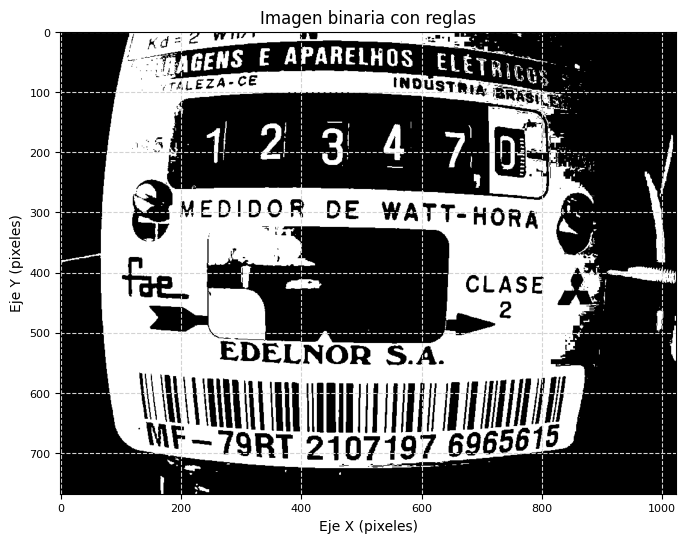

In [ ]:
mostrar_imagen_binaria_con_reglas(bin)

### funcion C

In [ ]:
def extraer_5_manchas_mas_grandes(img_binaria, blobs = 5, kernel_size = 3, tamaño_salida=28, margen=10):
    """
    Extrae las 5 manchas más grandes de una imagen binaria,
    las ordena de izquierda a derecha según su posición,
    aplica cierre morfológico, las centra y redimensiona.
    Devuelve una lista de imágenes (numpy arrays) de tamaño tamaño_salida x tamaño_salida.
    """

    # Encontrar todos los contornos
    contornos, _ = cv2.findContours(img_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contornos:
        return [np.zeros((tamaño_salida, tamaño_salida), dtype=np.uint8) for _ in range(blobs)]

    # Tomar los 5 contornos más grandes
    contornos_ordenados_area = sorted(contornos, key=cv2.contourArea, reverse=True)[:blobs]

    # Obtener información: (contorno, x de la bounding box)
    contornos_con_x = [(cnt, cv2.boundingRect(cnt)[0]) for cnt in contornos_ordenados_area]

    # Ordenar por posición x (de izquierda a derecha)
    contornos_ordenados_posicion = sorted(contornos_con_x, key=lambda x: x[1])

    manchas = []

    for contorno, _ in contornos_ordenados_posicion:
        x, y, w, h = cv2.boundingRect(contorno)
        roi = img_binaria[y:y+h, x:x+w]

        # Cierre morfológico
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        roi_cerrado = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)

        # Añadir margen
        roi_con_margen = cv2.copyMakeBorder(
            roi_cerrado, margen, margen, margen, margen,
            borderType=cv2.BORDER_CONSTANT, value=0
        )

        # Redimensionar manteniendo proporción
        h_m, w_m = roi_con_margen.shape
        escala = min(tamaño_salida / w_m, tamaño_salida / h_m)
        nuevo_w = int(w_m * escala)
        nuevo_h = int(h_m * escala)
        roi_redim = cv2.resize(roi_con_margen, (nuevo_w, nuevo_h), interpolation=cv2.INTER_AREA)

        # Centrar
        resultado = np.zeros((tamaño_salida, tamaño_salida), dtype=np.uint8)
        x_offset = (tamaño_salida - nuevo_w) // 2
        y_offset = (tamaño_salida - nuevo_h) // 2
        resultado[y_offset:y_offset+nuevo_h, x_offset:x_offset+nuevo_w] = roi_redim
        manchas.append(resultado)
    return manchas

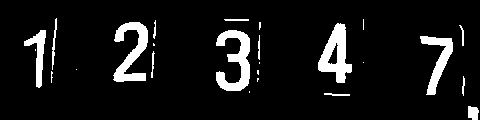

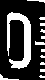

In [ ]:
img_binaria = bin[130:250, 220:700]
cv2_imshow(img_binaria)
img_binaria2 = bin[160:240, 725:770]
cv2_imshow(img_binaria2)

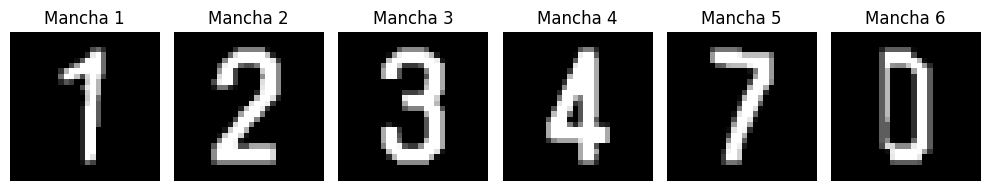

In [ ]:
def mostrar_manchas(manchas):
    """
    Muestra las manchas en una sola fila usando matplotlib.
    """
    plt.figure(figsize=(10, 2))
    for i, mancha in enumerate(manchas):
        plt.subplot(1, 6, i+1)
        plt.imshow(mancha, cmap='gray')
        plt.axis('off')
        plt.title(f'Mancha {i+1}')
    plt.tight_layout()
    plt.show()

# Extraer manchas
manchas = extraer_5_manchas_mas_grandes(img_binaria, 5, 3)
mancha2_list = extraer_5_manchas_mas_grandes(img_binaria2, 1, 5)
manchas.append(mancha2_list[0])

# Mostrarlas
mostrar_manchas(manchas)

In [ ]:
# Crear carpeta de salida
output_folder = '/content/digitos_28x28'
os.makedirs(output_folder, exist_ok=True)

# Guardar cada imagen como PNG
for i, img in enumerate(manchas):
    path = os.path.join(output_folder, f'digito_{i+1}.png')
    cv2.imwrite(path, img)

shutil.make_archive('/content/digitos_28x28_zip', 'zip', output_folder)

'/content/digitos_28x28_zip.zip'

In [ ]:
import os
import cv2

# Ruta donde se extrajo el zip
input_folder = "/content/medidores"
imagenes = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.png'))])

print("Total de imágenes encontradas:", len(imagenes))

# Intentamos leer la primera imagen
if imagenes:
    img_path = os.path.join(input_folder, imagenes[0])
    imagen = cv2.imread(img_path)
    if imagen is None:
        print(f"No se pudo cargar la imagen: {img_path}")
    else:
        print("Dimensiones de la primera imagen:", imagen.shape)
else:
    print("No se encontraron imágenes.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/medidores'

In [ ]:
import zipfile
import os
import shutil
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

# FUNCIÓN COMPLETA
def procesar_zip_de_medidores():
    from google.colab import files # Import files inside the function

    # Subir ZIP
    uploaded = files.upload()
    zip_path = next(iter(uploaded))
    input_folder = "/content/medidores"
    os.makedirs(input_folder, exist_ok=True)

    # Extraer ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(input_folder)

    # Crear carpeta de salida
    output_folder = "/content/recortes"
    os.makedirs(output_folder, exist_ok=True)

    # Procesar cada imagen
    imagenes = []
    for root, _, files_in_dir in os.walk(input_folder): # Renamed files to files_in_dir to avoid conflict
        for file in files_in_dir:
            if file.lower().endswith(('.jpg', '.png')):
                imagenes.append(os.path.join(root, file))

    for idx, nombre in enumerate(tqdm(imagenes, desc="Procesando imágenes")):
        path = os.path.join(input_folder, nombre)
        imagen = cv2.imread(path)

        if imagen is None:
            continue

        binarizada = binarizar(imagen)

        # Recortes
        img_binaria = binarizada[130:250, 220:700]
        img_binaria2 = binarizada[160:240, 725:770]

        # Extraer manchas
        manchas = extraer_5_manchas_mas_grandes(img_binaria, 5, 3)
        mancha_extra = extraer_5_manchas_mas_grandes(img_binaria2, 1, 5)

        if mancha_extra:
            manchas.append(mancha_extra[0])

        # Guardar manchas
        base = f"img_{str(idx+1).zfill(3)}"
        for i, m in enumerate(manchas):
            path_salida = os.path.join(output_folder, f"{base}_{i}.png")
            cv2.imwrite(path_salida, m)

    # Comprimir en ZIP
    zip_final = "/content/recortes.zip"
    shutil.make_archive("/content/recortes", 'zip', output_folder)

    # Descargar
    files.download(zip_final)
procesar_zip_de_medidores()

In [ ]:
import cv2
import numpy as np
import zipfile
import os
from io import BytesIO

def procesar_zip(input_zip_path, output_zip_path):
    """
    Procesa un archivo ZIP de imágenes, extrae manchas de dos regiones específicas,
    combina 6 manchas por imagen (5 de la primera región + 1 de la segunda),
    y guarda todas las manchas en un nuevo ZIP.

    Parámetros:
        input_zip_path (str): Ruta al ZIP de entrada con imágenes.
        output_zip_path (str): Ruta donde se guardará el ZIP de salida.
    """
    # 1. Inicializar ZIP de salida
    with zipfile.ZipFile(output_zip_path, 'w') as zip_out:
        # 2. Abrir ZIP de entrada
        with zipfile.ZipFile(input_zip_path, 'r') as zip_in:
            # 3. Procesar cada imagen en el ZIP
            for filename in zip_in.namelist():
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        # Leer imagen y convertir a BGR (OpenCV)
                        with zip_in.open(filename) as file:
                            img_data = np.frombuffer(file.read(), np.uint8)
                            img = cv2.imdecode(img_data, cv2.IMREAD_COLOR)

                        # Binarizar la imagen
                        bin_img = binarizar(img, mostrar=0)

                        # Definir regiones de recorte (ajustadas a índices válidos)
                        height, width = bin_img.shape
                        roi1 = bin_img[
                            max(130, 0):min(250, height),
                            max(220, 0):min(700, width)
                        ]
                        roi2 = bin_img[
                            max(160, 0):min(240, height),
                            max(725, 0):min(770, width)
                        ]

                        # Extraer manchas
                        manchas_roi1 = extraer_5_manchas_mas_grandes(roi1, 5, 1)
                        manchas_roi2 = extraer_5_manchas_mas_grandes(roi2, 1, 5)

                        # Combinar todas las manchas (5 + 1)
                        todas_manchas = manchas_roi1 + manchas_roi2

                        # 4. Guardar cada mancha en el ZIP de salida
                        base_name = os.path.splitext(os.path.basename(filename))[0]
                        for idx, mancha in enumerate(todas_manchas):
                            # Convertir a formato PNG
                            _, img_encoded = cv2.imencode('.png', mancha)
                            mancha_name = f"{base_name}_mancha_{idx}.png"
                            zip_out.writestr(mancha_name, img_encoded.tobytes())

                    except Exception as e:
                        print(f"Error procesando {filename}: {str(e)}")

# Funciones auxiliares (definiciones previas)
def binarizar(imagen, mostrar=0):
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    _, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binaria

def extraer_5_manchas_mas_grandes(img_binaria, blobs=5, kernel_size=3, tamaño_salida=28, margen=10):
    contornos, _ = cv2.findContours(img_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contornos:
        return [np.zeros((tamaño_salida, tamaño_salida), dtype=np.uint8) for _ in range(blobs)]

    contornos_ordenados = sorted(contornos, key=cv2.contourArea, reverse=True)[:blobs]
    contornos_con_x = [(cnt, cv2.boundingRect(cnt)[0]) for cnt in contornos_ordenados]
    contornos_ordenados_posicion = sorted(contornos_con_x, key=lambda x: x[1])

    manchas = []
    for contorno, _ in contornos_ordenados_posicion:
        x, y, w, h = cv2.boundingRect(contorno)
        roi = img_binaria[y:y+h, x:x+w]
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        roi_cerrado = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)
        roi_margen = cv2.copyMakeBorder(roi_cerrado, margen, margen, margen, margen, cv2.BORDER_CONSTANT, value=0)
        h_m, w_m = roi_margen.shape
        escala = min(tamaño_salida / w_m, tamaño_salida / h_m)
        nuevo_w, nuevo_h = int(w_m * escala), int(h_m * escala)
        roi_redim = cv2.resize(roi_margen, (nuevo_w, nuevo_h), interpolation=cv2.INTER_AREA)
        resultado = np.zeros((tamaño_salida, tamaño_salida), dtype=np.uint8)
        x_offset = (tamaño_salida - nuevo_w) // 2
        y_offset = (tamaño_salida - nuevo_h) // 2
        resultado[y_offset:y_offset+nuevo_h, x_offset:x_offset+nuevo_w] = roi_redim
        manchas.append(resultado)
    return manchas

In [ ]:
# Ejemplo de uso
procesar_zip('imagenes_entrada.zip', 'manchas_salida.zip')